# 1. Setting-up

1.1 Import required libraries

In [ ]:
import heapq
import string
from nltk.corpus import stopwords
import re
import itertools
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

1.2 Loading the datasets

In [ ]:
all_series_df= pd.read_csv('all_series.csv')
people_df = pd.read_csv('people.csv')
production_companies_df = pd.read_csv('production_companies.csv')
networks_df = pd.read_csv('networks.csv')
genres_df = pd.read_csv('genres.csv')


# 2. Exploratory Data Analysis

2.1 Overview of Dataset

In [ ]:
all_series_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tmdb_id                   1515 non-null   int64  
 1   name                      1515 non-null   object 
 2   original_name             1515 non-null   object 
 3   keywords                  966 non-null    object 
 4   airing_date               1451 non-null   object 
 5   poster_img_url            1414 non-null   object 
 6   background_img_url        1179 non-null   object 
 7   directors_ids             165 non-null    object 
 8   cast_ids                  1485 non-null   object 
 9   genres_ids                1515 non-null   object 
 10  number_of_seasons         1511 non-null   float64
 11  number_of_episodes        1502 non-null   float64
 12  episode_run_time          1289 non-null   float64
 13  synopsis                  1432 non-null   object 
 14  populari

2.2 Data cleaning

*  Create a new DataFrame
*   Converts IDs to actual words



In [ ]:
##creates a new DataFrame named series by selecting specific columns
series = all_series_df[["tmdb_id", "name", "directors_ids", "cast_ids", "genres_ids", "synopsis", "networks_ids", "production_companies_ids", "airing_date", "number_of_episodes"]]

In [ ]:
#Converting IDs from genres, networks, production_companies, directors, and cast into words
def translate_ids_to_names(main_df, target_column, target_df):

    # going through each list of ids (column cell)
    for index, value in main_df[target_column].iteritems():

        new_values = []

        if not pd.isna(value):
            values = value.split(", ")

            for element in values:

                id = int(element)
                name = target_df.loc[target_df["tmdb_id"] == id, "name"].item()

                new_values.append(name)

            if not new_values:
                print("ERROR")
            else:
                new_values = ", ".join(new_values)
                main_df.at[index, target_column] = new_values

In [ ]:
#tranalste IDs to names for necessary  columns
translate_ids_to_names(series, "genres_ids", genres_df)
translate_ids_to_names(series, "networks_ids", networks_df)
translate_ids_to_names(series, "production_companies_ids", production_companies_df)
translate_ids_to_names(series, "directors_ids", people_df)
translate_ids_to_names(series, "cast_ids", people_df)

<ipython-input-95-a443a2389825>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in main_df[target_column].iteritems():


In [ ]:
#Rename IDs Counlmns
new_columns = {"genres_ids": "genres", "networks_ids": "networks", "production_companies_ids": "production_companies", "directors_ids": "directors","cast_ids": "cast"}
series = series.rename(columns = new_columns)
series

,tmdb_id,name,directors,cast,genres,synopsis,networks,production_companies,airing_date,number_of_episodes
0,136699,Glitch,Roh Deok,"Jeon Yeo-been, Nana, Lee Dong-hwi, Ryu Kyung-s...","Drama, Comedy, Mystery, Sci-Fi & Fantasy",A young woman joins forces with a UFO enthusia...,Netflix,Studio 329,2022-10-07,10.0
1,99966,All of Us Are Dead,JQ Lee,"Park Ji-hu, Yoon Chan-young, Cho Yi-hyun, Lomo...","Action & Adventure, Drama, Sci-Fi & Fantasy",A high school becomes ground zero for a zombie...,Netflix,"Kim Jong-hak Production, SLL, Film Monster",2022-01-28,12.0
2,93405,Squid Game,Hwang Dong-hyuk,"Lee Jung-jae, Park Hae-soo, Jung Ho-yeon, Wi H...","Action & Adventure, Mystery, Drama",Hundreds of cash-strapped players accept a str...,Netflix,Siren Pictures,2021-09-17,9.0
3,112836,Money Heist: Korea - Joint Economic Area,NaN,"Yoo Ji-tae, Yunjin Kim, Park Hae-soo, Jeon Jon...","Action & Adventure, Crime, Drama, Mystery","Disguised under the shadows of a mask, a crew ...",Netflix,"Content Zium, BH Entertainment",2022-06-24,6.0
4,112888,True Beauty,NaN,"Moon Ga-young, Cha Eun-woo, Hwang In-yeop, Par...","Comedy, Drama",Lim Ju-kyung is a high school student. Since s...,tvN,"Bon Factory, Studio Dragon, Studio N",2020-12-09,16.0
...,...,...,...,...,...,...,...,...,...,...
1510,14144,Happy Woman,NaN,"Yoon Jung-hee, Jung Gyu-woon, Kim Suk-hoon, Pa...",Drama,NaN,KBS2,NaN,2007-01-06,1.0
1511,14070,Mina,NaN,Chae Jung-an,Drama,Mina was a 20-episode South Korean drama broad...,KBS2,NaN,2001-11-05,16.0
1512,12062,Salut D'Amour,NaN,Sung Hyun-ah,"Drama, Comedy","Salut D'Amour, despite its French name, is a S...",KBS2,NaN,1994-11-01,1.0
1513,212594,She Makes My Heart Flutter,NaN,NaN,Drama,"Two women, one outgoing and one shy, work toge...",NaN,SOO NOT SUE studio,2022-10-20,1.0


2.3 Handling Missing/Duplicate Values

In [ ]:
#filling missing values

for column in series.columns:
    if series[column].dtype == 'object':
        mode_value = series[column].mode()[0]
        series[column].fillna(mode_value, inplace=True)
    elif series[column].dtype == 'float64':
        series[column].fillna(series[column].mean(), inplace=True)
    elif series[column].dtype == 'int64':
        series[column].fillna(series[column].median(), inplace=True)
    else:
      pass


In [ ]:
#checks for any missing values/
series.isna().sum()

tmdb_id                 0
name                    0
directors               0
cast                    0
genres                  0
synopsis                0
networks                0
production_companies    0
airing_date             0
number_of_episodes      0
dtype: int64

In [ ]:
new_series = series[["tmdb_id", "name", "cast", "genres", "synopsis","airing_date","networks","number_of_episodes"]]


In [ ]:
#Check for Duplicate
new_series.duplicated().sum()

0

3.3 Checking Data type for a new DataFrame

In [ ]:
print(f"Shape: {new_series.shape}")
print(f"Time Period: {new_series['airing_date'].min()}-{new_series['airing_date'].max()}")
print("Data Dictionary: ")
new_series.info()

Shape: (1515, 8)
Time Period: 1983-03-31-2023-06-30
Data Dictionary: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tmdb_id             1515 non-null   int64  
 1   name                1515 non-null   object 
 2   cast                1515 non-null   object 
 3   genres              1515 non-null   object 
 4   synopsis            1515 non-null   object 
 5   airing_date         1515 non-null   object 
 6   networks            1515 non-null   object 
 7   number_of_episodes  1515 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 94.8+ KB


# 3.Visualization

3.1 Exploring Genres of K-Drama

In [ ]:
# Categorical Data Analysis
# Genre distribution
genre_counts = new_series['genres'].str.split(',').explode().str.strip().value_counts()


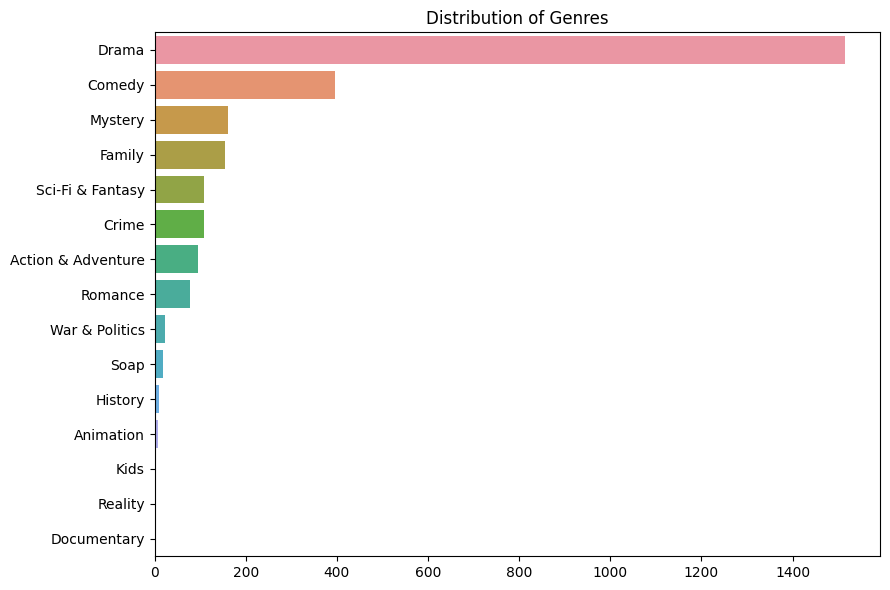

In [ ]:
# Plotting the distribution
plt.figure(figsize=(9, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Distribution of Genres')
plt.tight_layout()
plt.show()

3.2 Exploring the distribution of top 15 K-Drama Networks.

In [ ]:
# Network distribution
network_counts = new_series['networks'].str.split(',').explode().str.strip().value_counts()

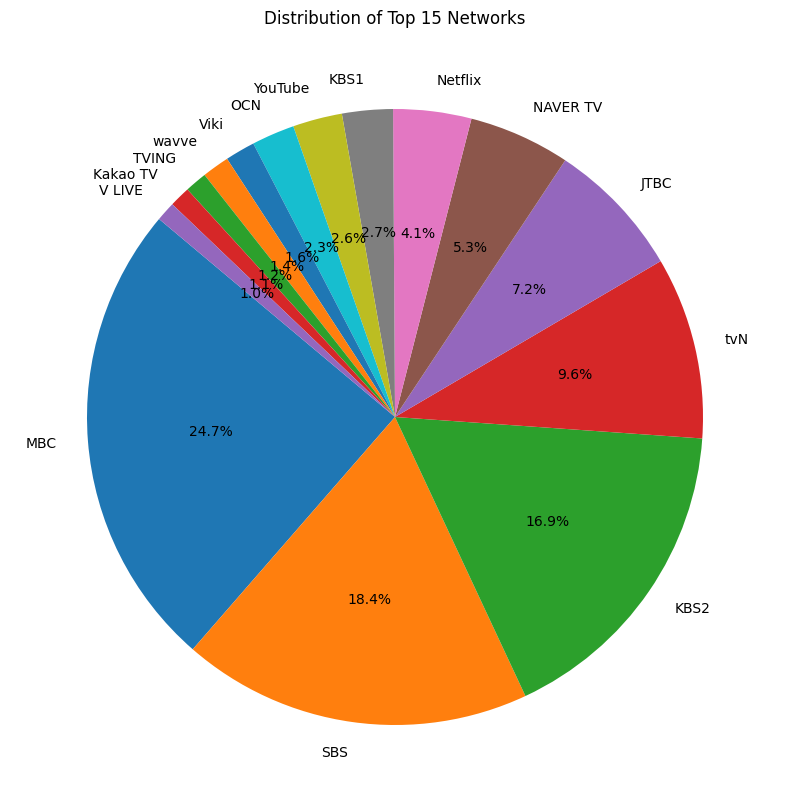

In [ ]:
top_15_network_counts = network_counts.nlargest(15)
# Plotting the distribution of the top 30 networks as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(top_15_network_counts, labels=top_15_network_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Top 15 Networks')
plt.show()

3.3 analysis for how many K-Drama has been released in each year

In [ ]:
new_series['airing_date'] = pd.to_datetime(new_series['airing_date'])

# Extract just the year from the 'airing_date' column
new_series['year'] = new_series['airing_date'].dt.year

<ipython-input-107-d4f4a1b9b2df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_series['airing_date'] = pd.to_datetime(new_series['airing_date'])
<ipython-input-107-d4f4a1b9b2df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_series['year'] = new_series['airing_date'].dt.year


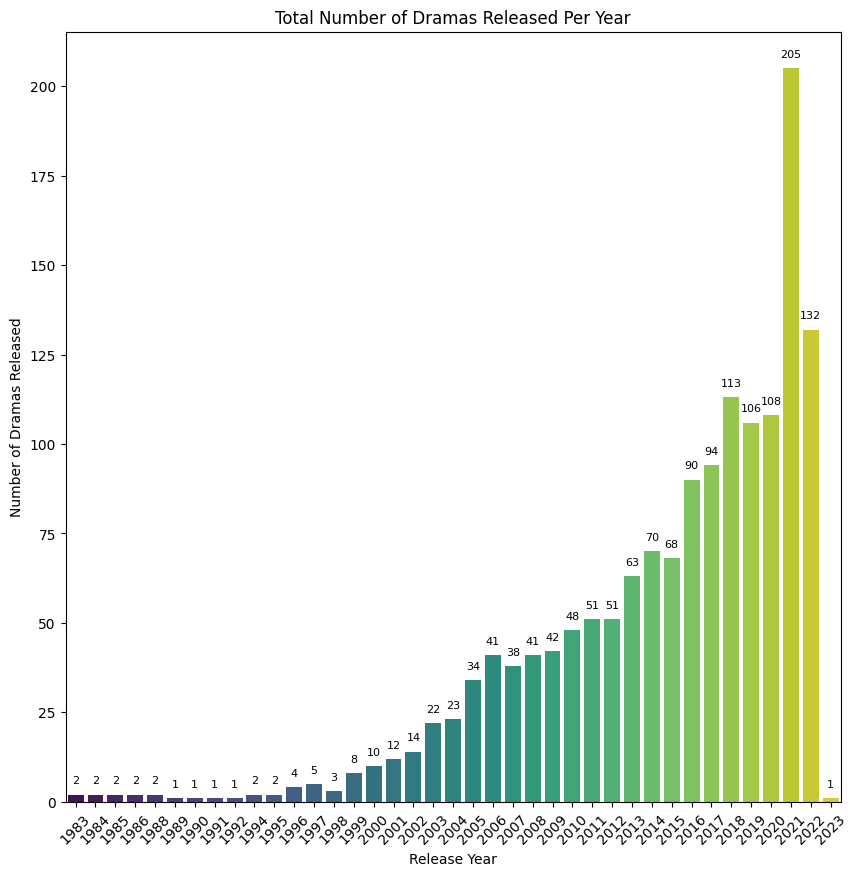

In [ ]:
# Count the number of dramas released per year
dramas_per_year = new_series['year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10,10))
ax = sns.barplot(x=dramas_per_year.index, y=dramas_per_year.values, palette="viridis")

# Adding data labels
for p, label in zip(ax.patches, dramas_per_year.values):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

# Setting labels and title
plt.xlabel("Release Year")
plt.ylabel("Number of Dramas Released")
plt.title("Total Number of Dramas Released Per Year")
plt.xticks(rotation=45)

plt.show()

3.4 Filtering Recommendation
  * For first-time users, they can filter K-Drama by desired number of episodes to try out K-Drama.

In [ ]:
#Filtering Drama by Number of Episode
epi = int(input("Enter your atmost number of episodes:"))
filtered_dramas = new_series[new_series['number_of_episodes'] <= epi]
top_dramas = filtered_dramas.sort_values(by=['name','number_of_episodes'], ascending=[False, False]).head(5)

# Selecting specific columns
selected_columns = ['year',
       'number_of_episodes', 'networks',
       'synopsis', 'cast', 'genres', ]

# Displaying the top 5 rows with selected columns
result = top_dramas[selected_columns]
result.head()

Enter your atmost number of episodes:12


,year,number_of_episodes,networks,synopsis,cast,genres
1416,2019,5.0,MBC,Tea master Hong won the Winter Course Competit...,"Park Ji An, Shin Hyun Jin, Lee Yoo Ri",Drama
226,2020,12.0,"KBS2, wavve",Kim Moo-Young has been a zombie for the past 2...,"Choi Jin-hyuk, Park Ju-hyun, Hwang Bo-ra, Kwon...","Sci-Fi & Fantasy, Mystery, Comedy, Drama"
1299,2021,1.0,tvN,About a prince suffering from a mysterious cur...,"Park Hyung-sik, Jeon So-nee, Pyo Ye-jin, Yun J...","Mystery, Drama"
305,2021,12.0,"KBS2, wavve","Set in 1980s during the Gwangju Uprising, Yout...","Lee Do-hyun, Go Min-si, Lee Sang Yi, Geum Sae-...",Drama
1313,2021,10.0,MBC,"Centered around a secret composer, fans, and f...","Yoon San-ha, Park Su-min, Han Gi-chan",Drama


3.5 exploring top 50 common words in Synopsis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


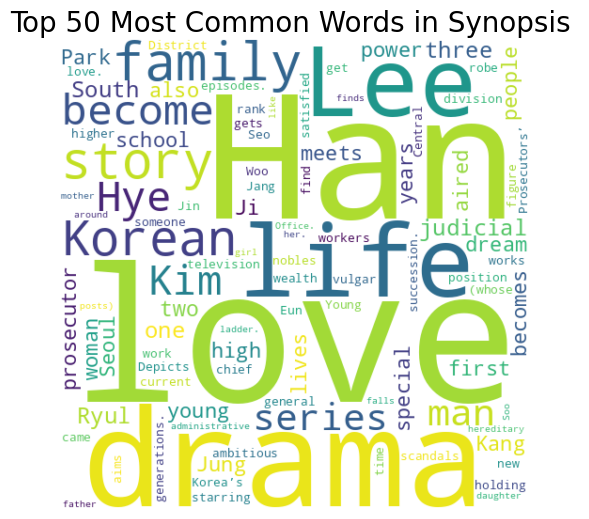

In [ ]:
# Download the stopwords from NLTK
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Assuming 'synopsis' is the column containing text data in raw_series_df
text_column = new_series['synopsis']

# Split text into words and remove stopwords
words = [word for text in text_column for word in text.split() if word.lower() not in stop_words]

# Get the most common words
most_common_words = FreqDist(words).most_common(100)

# Generate Word Cloud
wordcloud = WordCloud(width=500, height=500, background_color='white').generate_from_frequencies(dict(most_common_words))

# Display Word Cloud
fig = plt.figure(figsize=(5, 5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words in Synopsis ', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

# 4. Recommender System using Cosine Similarity  

4.1 Content-based recommender

In [ ]:
new_series['synopsis'].head()

0    A young woman joins forces with a UFO enthusia...
1    A high school becomes ground zero for a zombie...
2    Hundreds of cash-strapped players accept a str...
3    Disguised under the shadows of a mask, a crew ...
4    Lim Ju-kyung is a high school student. Since s...
Name: synopsis, dtype: object

In [ ]:
import nltk
import string

nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



*    Removing stop words such as "a," "an," "the," "is," "am," and others. Additionally, eliminate any special characters, punctuation, and digits.


In [ ]:
def preprocess_text(text):
    if text is None or isinstance(text, list):
        return ""
    text = str(text).lower()

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]

    cleaned_text = ' '.join(words)
    return cleaned_text


In [ ]:
new_series['synopsis_cleaned']=new_series['synopsis'].apply(preprocess_text)

In [ ]:
new_series['synopsis_cleaned'].head()

0    young woman joins forces ufo enthusiast invest...
1    high school becomes ground zero zombie virus o...
2    hundreds cashstrapped players accept strange i...
3    disguised shadows mask crew desperados band to...
4    lim jukyung high school student since little c...
Name: synopsis_cleaned, dtype: object





*    Conversion of text data in the "Synopsis" column into neumerical vectors using TF-IDF
*    Calculation of Cosine Similarity between the vectors generated by TF-IDF for recommendation
*   In the **create_indices** function, we generate a list of unique dramas from the DataFrame for recommendation..

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(new_series['synopsis_cleaned'])

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def create_indices(data):
    return data.index.to_series(index=data['name']).drop_duplicates()

indices = create_indices(new_series)

*    This function, **drama_recommendations**, takes the title of a Korean drama, a set of precomputed indices, a cosine similarity matrix, and a parameter for the number of top recommendations. It finds the index of the given drama, retrieves its cosine similarity scores with other dramas, identifies the top N similar dramas, and returns the names

In [ ]:
def drama_recommendations(title, ind=indices, cosine_sim=cosine_sim, top_n=5):
    idx = ind.get(title)
    if idx is None:
        print(f"Drama '{title}' not found.")
        return pd.Series()
    sim_scores = cosine_sim[idx]
    top_indices = heapq.nlargest(top_n, range(len(sim_scores)), sim_scores.__getitem__)
    return new_series['name'].iloc[top_indices]

In [ ]:
#Result Display
drama_recommendations("Glitch")

0                 Glitch
363            Possessed
1274        Soul Special
254       Criminal Minds
813     Long Time No See
Name: name, dtype: object

4.2 Synopsis, Genre, and Cast Based recommender

In [ ]:
new_series['Tag_cleaned']=new_series['synopsis'].apply(preprocess_text)
new_series['Genre_cleaned']=new_series['genres'].apply(preprocess_text)
new_series['Cast_cleaned']=new_series['cast'].apply(preprocess_text)

*   concatinate above three column **Genre_cleaned**, **Genre_cleaned**, and **Genre_cleaned**.

In [ ]:
def concatenate_columns(row):
    concatenated_values = []

    for column in ['Tag_cleaned', 'Genre_cleaned', 'Cast_cleaned']:
        value = row[column]

        # Check if the value is a list, and join its elements into a string
        if isinstance(value, list):
            value = ' '.join(value)

        concatenated_values.append(value)

    return ' '.join(concatenated_values)


new_series['attribute_based'] = new_series.apply(concatenate_columns, axis=1)

*   the concatinated column **attribute_based** in text form so here we convert it to neumerical vectors for recommendation with **CountVectorizer**
*   Calculation of Cosine Similarity of **count_matrix_attribute**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_matrix_attribute = count_vectorizer.fit_transform(new_series['attribute_based'])
cosine_sim_attrubute_base = linear_kernel(count_matrix_attribute, count_matrix_attribute)

In [ ]:
cosine_sim_attrubute_base

array([[72., 16., 13., ...,  2., 12., 12.],
       [16., 38., 11., ...,  1.,  4.,  4.],
       [13., 11., 39., ...,  1.,  5.,  4.],
       ...,
       [ 2.,  1.,  1., ..., 18.,  1.,  1.],
       [12.,  4.,  5., ...,  1., 35.,  6.],
       [12.,  4.,  4., ...,  1.,  6., 20.]])

In [ ]:
#result Display
recommended_drama=drama_recommendations("Business Proposal",cosine_sim=cosine_sim_attrubute_base)
print(recommended_drama)

7             Business Proposal
100                Mr. Sunshine
54                   Empress Ki
242        Sungkyunkwan Scandal
609    The Kingdom of the Winds
Name: name, dtype: object


# 5. Building an App using Streamlit